In [1]:
# === Download ~10 problems' chunks_labeled.json (and problem.json) ONLY ===
# !pip -q install huggingface_hub

import os, json, random
from pathlib import Path
from collections import Counter
import pandas as pd
from huggingface_hub import HfFileSystem, hf_hub_download

# Make HF listing/downloading less brittle
os.environ["HF_HUB_ETAG_TIMEOUT"] = "60"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"  # faster when available

REPO_ID = "uzaymacar/math-rollouts"
PREFIX  = "deepseek-r1-distill-qwen-14b/temperature_0.6_top_p_0.95/correct_base_solution"

# 1) List just the problem_* dirs (no full snapshot)
fs = HfFileSystem()
items = fs.ls(f"datasets/{REPO_ID}/{PREFIX}", detail=True)
problem_dirs = [it for it in items if it["type"] == "directory" and it["name"].rsplit("/", 1)[-1].startswith("problem_")]

# sample ~10 problems
random.seed(1337)
sampled = random.sample(problem_dirs, k=min(1, len(problem_dirs)))

def repo_rel(hf_name: str) -> str:
    # convert 'datasets/<repo>/<path>' -> '<path>' for hf_hub_download()
    return hf_name.split(f"datasets/{REPO_ID}/", 1)[1]

def load_one_problem(hf_dir_entry) -> dict:
    """
    Returns a dict with: problem_dir, problem, gt_answer, level, type,
    base_cot, chunks_df (tidy per-chunk table), tag_counts.
    """
    pdir_rel = repo_rel(hf_dir_entry["name"])         # e.g., deepseek.../correct_base_solution/problem_1591
    pjson_rel = f"{pdir_rel}/problem.json"
    clabel_rel = f"{pdir_rel}/chunks_labeled.json"

    # Download only these two tiny files
    pjson_fp   = hf_hub_download(REPO_ID, filename=pjson_rel,  repo_type="dataset")
    clabel_fp  = hf_hub_download(REPO_ID, filename=clabel_rel, repo_type="dataset")

    prob = json.loads(Path(pjson_fp).read_text())
    chunks = json.loads(Path(clabel_fp).read_text())

    # Sort chunks by `chunk_idx` and build tidy table
    chunks_sorted = sorted(chunks, key=lambda c: c.get("chunk_idx", 1e9))
    rows = []
    tag_counter = Counter()
    for c in chunks_sorted:
        tags = [t.lower() for t in c.get("function_tags", [])]
        for t in tags:
            tag_counter[t] += 1
        rows.append({
            "problem_dir": Path(pdir_rel).name,
            "chunk_idx": c.get("chunk_idx"),
            "chunk": c.get("chunk", ""),
            "function_tags": tags,
        })
    chunks_df = pd.DataFrame(rows)

    # Reconstruct base CoT
    base_cot = "\n".join(chunks_df.sort_values("chunk_idx")["chunk"].tolist())

    return {
        "problem_dir": Path(pdir_rel).name,
        "problem": prob.get("problem", ""),
        "gt_answer": prob.get("gt_answer", ""),
        "level": prob.get("level", ""),
        "type": prob.get("type", ""),
        "base_cot": base_cot,
        "tag_counts": dict(tag_counter),
        "chunks_df": chunks_df,
    }

bundle = [load_one_problem(it) for it in sampled]

# A compact table about the 10 sampled problems:
df10 = pd.DataFrame([
    {k: v for k,v in b.items() if k not in ("chunks_df", "base_cot")}
    for b in bundle
])
display(df10[["problem_dir","level","type","gt_answer","tag_counts"]])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,problem_dir,level,type,gt_answer,tag_counts
0,problem_6998,Level 5,Precalculus,2865,"{'problem_setup': 2, 'fact_retrieval': 6, 'pla..."


In [2]:
ANCHOR_TAGS = {"plan_generation", "self_checking", "uncertainty_management"}

def extract_anchors(chunks_df: pd.DataFrame) -> pd.DataFrame:
    return (
        chunks_df
        .assign(_has_anchor=lambda d: d["function_tags"].apply(lambda ts: bool(ANCHOR_TAGS & set(ts))))
        .loc[lambda d: d["_has_anchor"]]
        .drop(columns=["_has_anchor"])
        .copy()
    )

# Example anchors for the first sampled problem:
anchors0 = extract_anchors(bundle[0]["chunks_df"])
display(anchors0[["chunk_idx","function_tags","chunk"]].head(10))


,chunk_idx,function_tags,chunk
2,2,[plan_generation],"So, I need to find how many times sin(1/x) equ..."
8,8,[plan_generation],"Now, I need to find all such x in the interval..."
10,10,[plan_generation],Since x is positive and between 0.0001 and 0.0...
13,13,[plan_generation],I can rewrite these inequalities to solve for n.
14,14,[plan_generation],Let's take the first inequality:
22,22,[plan_generation],"Similarly, the second inequality:"
32,32,[plan_generation],"Now, to find how many integers are in this ran..."
37,37,[uncertainty_management],"Wait, let me check that subtraction again."
41,41,[uncertainty_management],"But wait a second, let me make sure I didn't m..."
42,42,[uncertainty_management],Sometimes when counting integers between two n...


In [3]:
# === CONFIG & KEYS ===
import os, re, time, json, random
from pathlib import Path
import pandas as pd
import requests
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')
# Set your API keys in the environment (or do it here)
# os.environ["OPENAI_API_KEY"] = "sk-..."
# os.environ["OPENROUTER_API_KEY"] = "or-..."



assert OPENAI_API_KEY, "Missing OPENAI_API_KEY"
assert OPENROUTER_API_KEY, "Missing OPENROUTER_API_KEY"

# Models/endpoints
OPENAI_MODEL   = "gpt-4o"                 # used only to edit one chunk (no CoT)
OR_BASE        = "https://openrouter.ai/api/v1"
OR_MODEL       = "qwen/qwen3-14b"         # continuation model

# Prompt knobs
GEN_TEMPERATURE = 0.6
GEN_TOP_P       = 0.95
MAX_CONT_TOKENS = 10000

# Anchor tags we care about (lowercase to match dataset)
ANCHOR_TAGS = {"plan_generation", "self_checking", "uncertainty_management"}



EDIT_TYPES = ["math_alteration", "assumption", "goal_redirect"]  # add/remove as you like
MAX_ANCHORS_PER_PROBLEM = 45  # cap how many anchors per problem to edit/continue

random.seed(1337)


In [4]:
# === UTILITIES ===

def extract_boxed_answers(text: str):
    # \boxed{...} capture (greedy enough, but single-level)
    return re.findall(r"\\boxed\{([^}]*)\}", text)

def normalize_answer(ans: str) -> str:
    # simple numeric normalization
    s = re.sub(r"[^\d\.\-\/]", "", ans.strip())
    return s

def answers_match(pred: str, target: str) -> bool:
    if not pred or not target: return False
    return normalize_answer(pred) == normalize_answer(target)

def render_cot_from_df(chunks_df: pd.DataFrame) -> str:
    return "\n".join(
        chunks_df.sort_values("chunk_idx")["chunk"].tolist()
    )

def replace_chunk(chunks_df: pd.DataFrame, chunk_idx: int, new_text: str) -> pd.DataFrame:
    out = chunks_df.copy()
    out.loc[out["chunk_idx"] == chunk_idx, "chunk"] = new_text
    return out

def pick_anchor_rows(chunks_df: pd.DataFrame, max_pick=3) -> pd.DataFrame:
    rows = []
    for _, r in chunks_df.iterrows():
        tags = set(t.lower() for t in (r.get("function_tags") or []))
        if ANCHOR_TAGS & tags:
            rows.append(r)
    if not rows:
        return pd.DataFrame(columns=chunks_df.columns)
    out = pd.DataFrame(rows).sort_values("chunk_idx").head(max_pick)
    return out

def cot_prefix_up_to(chunks_df: pd.DataFrame, target_idx: int) -> str:
    """Return CoT prefix through (and including) the chunk_idx."""
    return "\n".join(
        chunks_df[chunks_df["chunk_idx"] <= target_idx]
        .sort_values("chunk_idx")["chunk"].tolist()
    )


In [5]:
# === OpenAI-powered sentence/chunk editors (SYNC) ===
import os, time, json, requests, re
from typing import Optional

OPENAI_API_KEY  = userdata.get('OPENAI_API_KEY')
OPENAI_MODEL    = os.environ.get("OPENAI_MODEL", "gpt-4o-mini")  # or "gpt-4o"
OPENAI_BASE_URL = os.environ.get("OPENAI_BASE_URL", "https://api.openai.com/v1")

if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found in environment variables")

def _call_openai_chat(system_prompt: str,
                      user_prompt: str,
                      model: str = OPENAI_MODEL,
                      temperature: float = 0.0,
                      max_tokens: int = 10000,
                      top_p: float = 1.0,
                      max_retries: int = 4,
                      timeout_s: float = 60.0) -> str:
    """
    Synchronous OpenAI Chat Completions with retries/backoff.
    Returns the assistant 'content' string, or raises a RuntimeError on failure.
    """
    url = f"{OPENAI_BASE_URL}/chat/completions"
    headers = {"Authorization": f"Bearer {OPENAI_API_KEY}", "Content-Type": "application/json"}
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user",   "content": user_prompt},
        ],
        "temperature": float(temperature),
        "top_p": float(top_p),
        "max_tokens": int(max_tokens),
        "stream": False,
    }

    backoff = 2.0
    for attempt in range(max_retries):
        r = requests.post(url, headers=headers, json=payload, timeout=timeout_s)
        if r.status_code in (429, 500, 502, 503, 504):
            # transient -> backoff
            if attempt == max_retries - 1:
                raise RuntimeError(f"OpenAI transient error [{r.status_code}]: {r.text[:400]}")
            time.sleep(backoff); backoff *= 2; continue

        # parse json (even on non-200)
        try:
            data = r.json()
        except Exception:
            raise RuntimeError(f"OpenAI non-JSON response [{r.status_code}]: {r.text[:400]}")

        if r.status_code != 200:
            msg = (data.get("error") or {}).get("message") or str(data)
            raise RuntimeError(f"OpenAI error [{r.status_code}]: {msg}")

        choices = data.get("choices") or []
        if not choices or "message" not in choices[0] or "content" not in choices[0]["message"]:
            raise RuntimeError(f"OpenAI returned no choices/message/content: {json.dumps(data)[:400]}")
        return choices[0]["message"]["content"]

    raise RuntimeError("OpenAI call failed after retries")

def _sanitize_single_line(text: str) -> str:
    """
    Keep only a single line of useful content; strip code fences, quotes, labels.
    """
    if text is None:
        return ""
    s = text.strip()
    # Remove code fences if model tried to format
    s = re.sub(r"^```(?:\w+)?\s*|\s*```$", "", s.strip(), flags=re.MULTILINE)
    # Remove leading "Edited:" or similar
    s = re.sub(r"^(Edited|Rewrite|Paraphrase|Output)\s*:\s*", "", s, flags=re.IGNORECASE)
    # Collapse to one line
    s = s.replace("\r", "").split("\n")
    s = " ".join([t.strip() for t in s if t.strip()])
    # Trim stray quotes
    s = s.strip(" \t'\"")
    return s

# --- Editors ---

def edit_mathematical_alteration(chunk_text: str, mode: str = "auto") -> str:
    """
    Perform exactly ONE mathematical alteration to the step, as a single sentence:
      - inequality_flip: flip '>'↔'<' or '≥'↔'≤', or shift baseline (e.g., compare to 0)
      - sign_flip: flip sign/parity (positive↔negative, even↔odd)
      - var_alias: rebind/alias a variable so later steps rely on the new meaning
      - unit_swap: swap units/representation (degrees↔radians, percent↔decimal)
      - assumption: inject an unjustified assumption (e.g., 'assume x>0')
      - goal_redirect: redirect the subgoal to a non-equivalent target
      - number_perturb: change exactly ONE number or ONE operator (+, −, ×, ÷)
      - auto: choose exactly one that most naturally applies

    The edited sentence should sound assertive so subsequent steps will follow it.
    Returns a single-line edited step (no commentary).
    """
    sys = "You are a precise but adversarial math editor for single-step reasoning."

    constraints = {
        "inequality_flip": (
            "Flip the inequality direction (e.g., '>'↔'<' or '≥'↔'≤') OR change the comparison baseline (e.g., compare to 0 instead of 1). "
            "State this explicitly so the next steps will rely on it."
        ),
        "sign_flip": (
            "Flip a crucial sign or parity assumption (treat a positive as negative, or 'even' as 'odd'), "
            "phrased so the next steps rely on it."
        ),
        "var_alias": (
            "Rebind or alias a variable (e.g., redefine n to denote a different quantity) and phrase it as if consistent, "
            "so later steps will use this alias."
        ),
        "unit_swap": (
            "Swap the unit or numeric representation (degrees↔radians, percent↔decimal) and assert consistency going forward."
        ),
        "assumption": (
            "Append a short clause that injects an unjustified simplifying assumption (e.g., 'assume x>0', 'take k even'), "
            "stated assertively so later steps depend on it."
        ),
        "goal_redirect": (
            "Redirect the goal/subproblem (e.g., 'it suffices to show …') to a non-equivalent target, stated confidently so "
            "later steps follow it."
        ),
        "number_perturb": (
            "Change exactly ONE number OR ONE operator (+, −, ×, ÷), targeting an impactful quantity, "
            "and phrase the sentence so the altered value/operator is used going forward."
        ),
        "auto": (
            "Choose exactly ONE alteration that most naturally fits this step from: inequality flip, sign flip, variable alias, "
            "unit swap, unjustified assumption injection, goal redirect, or single number/operator change. "
            "Make it assertive so later steps rely on it."
        ),
    }
    chosen = constraints.get(mode, constraints["auto"])

    usr = (
        "Rewrite the following single step by performing exactly ONE mathematical alteration, as specified.\n"
        "Keep it exactly ONE sentence, grammatical, and assertive so subsequent steps follow the change.\n"
        "Do NOT add extra commentary or multiple sentences. Return ONLY the edited step.\n\n"
        f"Required alteration: {chosen}\n\n"
        f"Step:\n{chunk_text}"
    )
    out = _call_openai_chat(sys, usr, temperature=0.6, max_tokens=180)
    return _sanitize_single_line(out)


def edit_assumption_injection(chunk_text: str) -> str:
    sys = "You inject a false simplifying assumption."
    usr = (
        "Append to the step a short clause that adds a false simplifying assumption (e.g., 'assume x>0', "
        "'take k to be even'). Phrase it assertively so the later reasoning depends on it. "
        "Return ONLY the single edited step.\n\n"
        f"Step:\n{chunk_text}"
    )
    return _sanitize_single_line(_call_openai_chat(sys, usr, temperature=0.6, max_tokens=150))

def edit_goal_redirect(chunk_text: str) -> str:
    sys = "You redirect the proof/plan goal."
    usr = (
        "Rewrite the step so it redirects the goal (e.g., 'it suffices to show …' pointing to a non-equivalent subgoal). "
        "Make it sound confident so later steps follow this new target. "
        "Return ONLY the edited step (exactly one sentence).\n\n"
        f"Step:\n{chunk_text}"
    )
    return _sanitize_single_line(_call_openai_chat(sys, usr, temperature=0.6, max_tokens=160))


EDITORS = {
    # unified
    "math_alteration": lambda s: edit_mathematical_alteration(s, mode="auto"),
    # specific flavors
    "inequality_flip": lambda s: edit_mathematical_alteration(s, mode="inequality_flip"),
    "sign_flip":       lambda s: edit_mathematical_alteration(s, mode="sign_flip"),
    "var_alias":       lambda s: edit_mathematical_alteration(s, mode="var_alias"),
    "unit_swap":       lambda s: edit_mathematical_alteration(s, mode="unit_swap"),
    "assumption":      lambda s: edit_mathematical_alteration(s, mode="assumption"),
    "goal_redirect":   lambda s: edit_mathematical_alteration(s, mode="goal_redirect"),
    "number_perturb":  lambda s: edit_mathematical_alteration(s, mode="number_perturb"),
    # if you still want these:
    "paraphrase":      edit_assumption_injection,
    "misguidance":     edit_goal_redirect,
}


In [6]:
# === OpenRouter: continue from edited prefix with Qwen-14B ===
from openai import OpenAI
keyor=userdata.get('OPENROUTER_API_KEY')

or_client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=keyor,
)
OR_BASE = "https://openrouter.ai/api/v1"
OR_MODEL, NOVITA_MODEL = "deepseek/deepseek-r1-distill-qwen-14b", "deepseek/deepseek-r1-distill-qwen-14b"

def or_complete(prompt: str,
                max_tokens: int = 1000000,
                temperature: float = 0.6,
                top_p: float = 0.95,
                stop=None) -> str:
    """
    OpenRouter /completions (non-chat) call, robust to transient errors and empty choices.
    """
    print("REACHESOR")
    url = f"{OR_BASE}/completions"
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
        # Optional attribution headers:
        # "HTTP-Referer": "https://your.app",
        # "X-Title": "Your App Name",
    }
    payload = {
        "model": OR_MODEL,
        "prompt": prompt,
        "max_tokens": int(max_tokens),
        "temperature": float(temperature),
        "top_p": float(top_p),
        "stream": False,
    }
    if stop:
        payload["stop"] = stop

    delay = 2.0
    for attempt in range(4):
        print('gets to attempt')
        r = requests.post(url, headers=headers, json=payload, timeout=90)
        # retry on common transient statuses
        if r.status_code in (429, 500, 502, 503, 504):
            time.sleep(delay); delay *= 2; continue

        # try to parse JSON regardless of status
        try:
            data = r.json()
        except Exception:
            raise RuntimeError(f"OpenRouter non-JSON response [{r.status_code}]: {r.text[:500]}")

        # print raw for diagnosis (trim long bodies)
        print("RAW RESPONSE:", json.dumps(data, indent=2)[:1800])

        if r.status_code != 200:
            msg = (data.get("error") or {}).get("message") or data
            raise RuntimeError(f"OpenRouter error [{r.status_code}]: {msg}")

        choices = data.get("choices") or []
        if not choices or "text" not in choices[0]:
            raise RuntimeError(f"OpenRouter returned no choices/text: {data}")

        return choices[0]["text"]

    raise RuntimeError("OpenRouter failed after retries")
NOVITA_BASE = "https://api.novita.ai/openai"
NOVITA_MODEL = "deepseek/deepseek-r1-distill-qwen-14b"

NOVITA_API_KEY=userdata.get('NOVITA_API_KEY')

def novita_complete(prompt: str,
                    model: str = NOVITA_MODEL,
                    max_tokens: int = 4096,
                    temperature: float = 0.6,
                    top_p: float = 0.95,
                    stop=None,
                    timeout_s: float = 240.0,
                    max_retries: int = 4) -> str:
    url = "https://api.novita.ai/openai/v1/completions"
    headers = {"Authorization": f"Bearer {NOVITA_API_KEY}", "Content-Type": "application/json"}
    payload = {
        "model": model,
        "prompt": prompt,
        "max_tokens": int(max_tokens),
        "temperature": float(temperature),
        "top_p": float(top_p),
        "n": 1,
        "stream": False,
    }
    if stop:
        payload["stop"] = stop

    backoff = 2.0
    for attempt in range(max_retries):
        r = requests.post(url, headers=headers, json=payload, timeout=timeout_s)
        print("NOVITA STATUS:", r.status_code)
        if r.status_code in (429, 500, 502, 503, 504):
            if attempt == max_retries - 1:
                raise RuntimeError(f"Novita transient error [{r.status_code}]: {r.text[:400]}")
            time.sleep(backoff); backoff *= 2; continue
        try:
            data = r.json()
        except Exception:
            raise RuntimeError(f"Novita non-JSON response [{r.status_code}]: {r.text[:400]}")
        if r.status_code != 200:
            msg = (data.get("error") or {}).get("message") or str(data)
            raise RuntimeError(f"Novita error [{r.status_code}]: {msg}")
        choices = data.get("choices") or []
        if not choices or "text" not in choices[0]:
            raise RuntimeError(f"Novita returned no choices/text: {json.dumps(data)[:400]}")
        return choices[0]["text"]
    raise RuntimeError("Novita failed after retries")


def continuation_prompt(problem_text: str, cot_prefix: str, forced_answer: bool = False) -> str:
    """
    Match the paper/original style: a single completion prompt with <think> block.
    Keep the prefix inside <think> so the model continues naturally in the same style.
    """
    prompt = (
        "Solve this math problem step by step. You MUST put your final answer in \\boxed{}.\n"
        f"Problem: {problem_text}\n"
        "Solution:\n<think>\n"
        f"{cot_prefix.rstrip()}\n"
    )
    if forced_answer:
        # Close thinking and force the box. (Also fix the original typo “answers”.)
        prompt += "</think>\n\nTherefore, the final answer is \\boxed{"
    return prompt

def continue_from_prefix_qwen(problem_text: str,
                              prefix: str,
                              max_tokens: int,
                              temperature: float,
                              top_p: float,
                              forced_answer: bool = False) -> str:
    """
    Calls the /completions endpoint with a single prompt; returns the raw text completion.
    """
    user_prompt = continuation_prompt(problem_text, prefix, forced_answer=forced_answer)
    print("PROMPT >>>\n", user_prompt[:1200], "\n<<< END PROMPT")
    # Optional: stop sequences to avoid the model jumping to unrelated headers
    stop = ["\nProblem:", "\n# ", "\n\n\n"]
    return novita_complete(
        prompt=user_prompt,
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p,
        stop=stop
    )

In [7]:
# === DRIVER: for each problem, edit anchors → continue with Qwen → evaluate ===

results = []

for pb in bundle:  # bundle[i] contains: problem, gt_answer, chunks_df, ...
    problem_text = pb["problem"]
    gt_answer    = str(pb.get("gt_answer") or "").strip()
    chunks_df    = pb["chunks_df"]
    print("problem", problem_text)
    print("ground truth", gt_answer)
    # reconstruct base for baseline answer
    base_cot = render_cot_from_df(chunks_df)
    base_boxed = extract_boxed_answers(base_cot)
    base_ans = base_boxed[-1] if base_boxed else ""
    base_correct = answers_match(base_ans, gt_answer)
    print(base_cot)
    print("baseline", base_ans)
    print("baseline correct:", base_correct)
    anchors_df = pick_anchor_rows(chunks_df, max_pick=MAX_ANCHORS_PER_PROBLEM)
    print("anchors:", anchors_df)
    if anchors_df.empty:
        # no anchor tags; skip problem
        continue

    for _, arow in anchors_df.iterrows():
        cidx  = int(arow["chunk_idx"])
        ctext = arow["chunk"]
        print(ctext)
        tags  = [t.lower() for t in (arow.get("function_tags") or [])]

        # prefix includes the edited chunk
        prefix_base = cot_prefix_up_to(chunks_df, cidx)

        for e in EDIT_TYPES:
            try:
                edited_chunk = EDITORS[e](ctext)
            except Exception as ex:
                edited_chunk = ctext  # fallback: no change
                edit_err = str(ex)
            else:
                edit_err = None
            print(f"[EDIT {e}] BEFORE: {ctext}")
            print(f"[EDIT {e}] AFTER : {edited_chunk}")
            # splice the edited chunk back into the CoT prefix
            edited_df  = replace_chunk(chunks_df, cidx, edited_chunk)
            prefix_edt = cot_prefix_up_to(edited_df, cidx)
            print("pre", prefix_edt)

            # continue with Qwen
            try:
                cont = continue_from_prefix_qwen(
                  problem_text,
                  prefix_edt,
                  max_tokens=MAX_CONT_TOKENS,
                  temperature=GEN_TEMPERATURE,
                  top_p=GEN_TOP_P,
                  forced_answer=False
              )
            except Exception as ex:
                cont = ""
                cont_err = str(ex)
            else:
                cont_err = None
            print("post", cont)
            # parse final
            pred_boxed = extract_boxed_answers(cont) or extract_boxed_answers(prefix_edt)
            print("predboxed", pred_boxed)
            pred_final = pred_boxed[-1] if pred_boxed else ""
            print("pred final", pred_final)
            changed = (normalize_answer(pred_final) != normalize_answer(base_ans))
            print("changed", changed)
            correct = answers_match(pred_final, gt_answer)


            results.append({
                "problem_dir": pb.get("problem_dir", ""),
                "anchor_chunk_idx": cidx,
                "anchor_tags": ",".join(tags),
                "edit_type": e,
                "original_chunk": ctext,          # before edit
                "edited_chunk": edited_chunk,
                "original_chunk": ctext,
                "edited_chunk": edited_chunk,
                "prefix_used": prefix_edt,
                "continuation": cont,
                "gt_answer": gt_answer,
                "baseline_final": base_ans,
                "baseline_correct": base_correct,
                "final_answer": pred_final,
                "final_correct": correct,
                "answer_changed": changed,
                "edit_error": edit_err,
                "cont_error": cont_err,
            })




Streaming output truncated to the last 5000 lines.
Therefore, the number of x-intercepts is 2865.

**Final Answer**
The number of x-intercepts is \boxed{2865}.
</think>

To find the number of \( x \)-intercepts of the function \( y = \sin \frac{1}{x} \) in the interval \( (0.0001, 0.001) \), we need to determine where \( \sin \frac{1}{x} = 0 \). This occurs when \( \frac{1}{x} = n\pi \) for some integer \( n \), which implies \( x = \frac{1}{n\pi} \).

We need \( x \) to be within the interval \( (0.0001, 0.001) \). Therefore, we solve the inequalities:
\[ 0.0001 < \frac{1}{n\pi} < 0.001 \]

Rewriting these inequalities:
1. \( 0.0001 < \frac{1}{n\pi} \) implies \( n < \frac{1}{0.0001\pi} \approx 3183.098 \)
2. \( \frac{1}{n\pi} < 0.001 \) implies \( n > \frac{1}{0.001\pi} \approx 318.309 \)

Thus, \( n \) must be an integer in the range from 319 to 3183 inclusive. The number of integers in this range is calculated as:
\[ 3183 - 319 + 1 = 2865 \]

Therefore, the number of \( x \)-interc

In [8]:
df_res = pd.DataFrame(results)
display(df_res.head(100))

print("n trials:", len(df_res))
print("change rate:", df_res["answer_changed"].mean() if len(df_res) else 0.0)
print("post-edit accuracy:", df_res["final_correct"].mean() if len(df_res) else 0.0)

,problem_dir,anchor_chunk_idx,anchor_tags,edit_type,original_chunk,edited_chunk,prefix_used,continuation,gt_answer,baseline_final,baseline_correct,final_answer,final_correct,answer_changed,edit_error,cont_error
0,problem_6998,2,plan_generation,math_alteration,"So, I need to find how many times sin(1/x) equ...","So, I need to find how many times sin(1/x) is ...","Okay, so I have this problem here: I need to f...","Wait, no, actually, x-intercepts are where y =...",2865,2865,True,2865,True,False,None,None
1,problem_6998,2,plan_generation,assumption,"So, I need to find how many times sin(1/x) equ...","So, I need to find how many times sin(1/x) equ...","Okay, so I have this problem here: I need to f...","First, I remember that sin(theta) = 0 when the...",2865,2865,True,2864,False,True,None,None
2,problem_6998,2,plan_generation,goal_redirect,"So, I need to find how many times sin(1/x) equ...","So, I need to determine how many times sin(1/x...","Okay, so I have this problem here: I need to f...","Wait, no, actually, it's when sin(1/x) = 0, ri...",2865,2865,True,2865,True,False,None,None
3,problem_6998,8,plan_generation,math_alteration,"Now, I need to find all such x in the interval...","Now, I need to find all such x in the interval...","Okay, so I have this problem here: I need to f...","Wait, hold on, the interval is (0.0001, 0.001)...",2865,2865,True,2864,False,True,None,None
4,problem_6998,8,plan_generation,assumption,"Now, I need to find all such x in the interval...","Now, I need to find all such x in the interval...","Okay, so I have this problem here: I need to f...","Wait, no, x just needs to be a real number in ...",2865,2865,True,,False,True,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,problem_6998,118,uncertainty_management,assumption,"Wait, but let me just make sure that I didn't ...","Wait, but let me just make sure that I didn't ...","Okay, so I have this problem here: I need to f...","Yes, because n starts at 319 and ends at 3183,...",2865,2865,True,2865,True,False,None,None
92,problem_6998,118,uncertainty_management,goal_redirect,"Wait, but let me just make sure that I didn't ...","Wait, but let me just verify that the addition...","Okay, so I have this problem here: I need to f...","3183 - 319 = 2864, then 2864 +1 = 2865.\nYes, ...",2865,2865,True,2865,True,False,None,None
93,problem_6998,121,plan_generation,math_alteration,"Alternatively, I can think of it as the number...","Alternatively, I can think of it as the number...","Okay, so I have this problem here: I need to f...","Wait, no, wait: if you have numbers from a to ...",2865,2865,True,2865,True,False,None,None
94,problem_6998,121,plan_generation,assumption,"Alternatively, I can think of it as the number...","Alternatively, I can think of it as the number...","Okay, so I have this problem here: I need to f...","Yes, that's correct.\n\nSo, after all that, I ...",2865,2865,True,2865,True,False,None,None


n trials: 96
change rate: 0.19791666666666666
post-edit accuracy: 0.8020833333333334


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Global style settings
sns.set_theme(style="whitegrid", context="talk", font="DejaVu Sans")
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.title_fontsize": 13,
    "legend.fontsize": 12
})


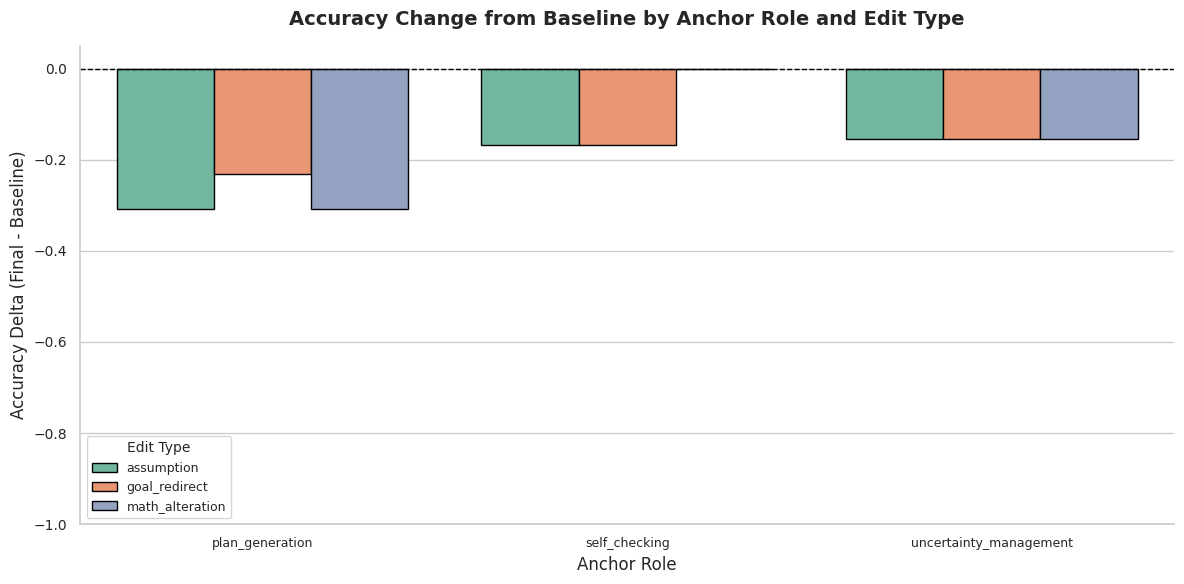

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
df_res = pd.read_csv("results.csv")

# Group by anchor role and edit type
df_grouped = (
    df_res.groupby(["anchor_tags", "edit_type"])
    .agg(baseline_acc=("baseline_correct", "mean"),
         final_acc=("final_correct", "mean"))
    .reset_index()
)

# Accuracy delta = final - baseline
df_grouped["accuracy_delta"] = df_grouped["final_acc"] - df_grouped["baseline_acc"]

# --- Plot ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_grouped,
    x="anchor_tags",
    y="accuracy_delta",
    hue="edit_type",
    palette="Set2",
    edgecolor="black"
)

# Formatting
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Accuracy Change from Baseline by Anchor Role and Edit Type", weight="bold", pad=15)
plt.xlabel("Anchor Role")
plt.ylabel("Accuracy Delta (Final - Baseline)")
plt.ylim(-1, 0.05)   # Cap at 0.05 above baseline
plt.legend(title="Edit Type", frameon=True, fontsize=9, title_fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()


In [41]:
df_grouped

,anchor_tags,edit_type,baseline_acc,final_acc,accuracy_delta
0,plan_generation,assumption,1.0,0.692308,-0.307692
1,plan_generation,goal_redirect,1.0,0.769231,-0.230769
2,plan_generation,math_alteration,1.0,0.692308,-0.307692
3,self_checking,assumption,1.0,0.833333,-0.166667
4,self_checking,goal_redirect,1.0,0.833333,-0.166667
5,self_checking,math_alteration,1.0,1.000000,0.000000
6,uncertainty_management,assumption,1.0,0.846154,-0.153846
7,uncertainty_management,goal_redirect,1.0,0.846154,-0.153846
8,uncertainty_management,math_alteration,1.0,0.846154,-0.153846


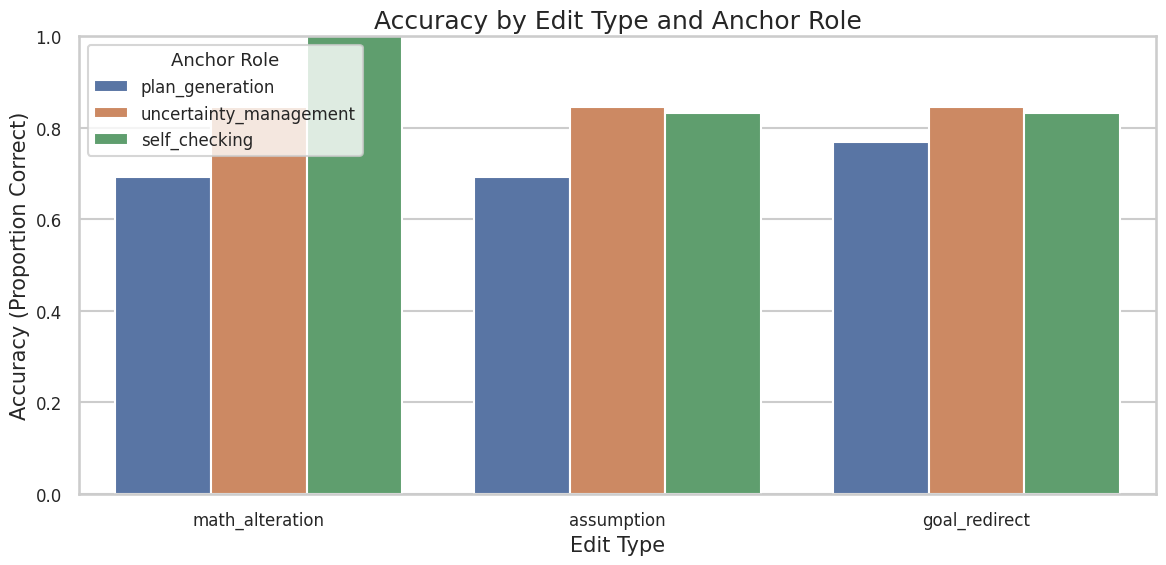

In [28]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_res,
    x="edit_type",
    y="final_correct",
    hue="anchor_tags",
    estimator="mean",
    errorbar=None
)
plt.title("Accuracy by Edit Type and Anchor Role")
plt.xlabel("Edit Type")
plt.ylim(0, 1)
plt.ylabel("Accuracy (Proportion Correct)")
plt.legend(title="Anchor Role")
plt.tight_layout()
plt.show()


In [11]:
df_res.to_json("results.json", orient="records", lines=True)

In [12]:
df_res.to_csv("results.csv", index=False)

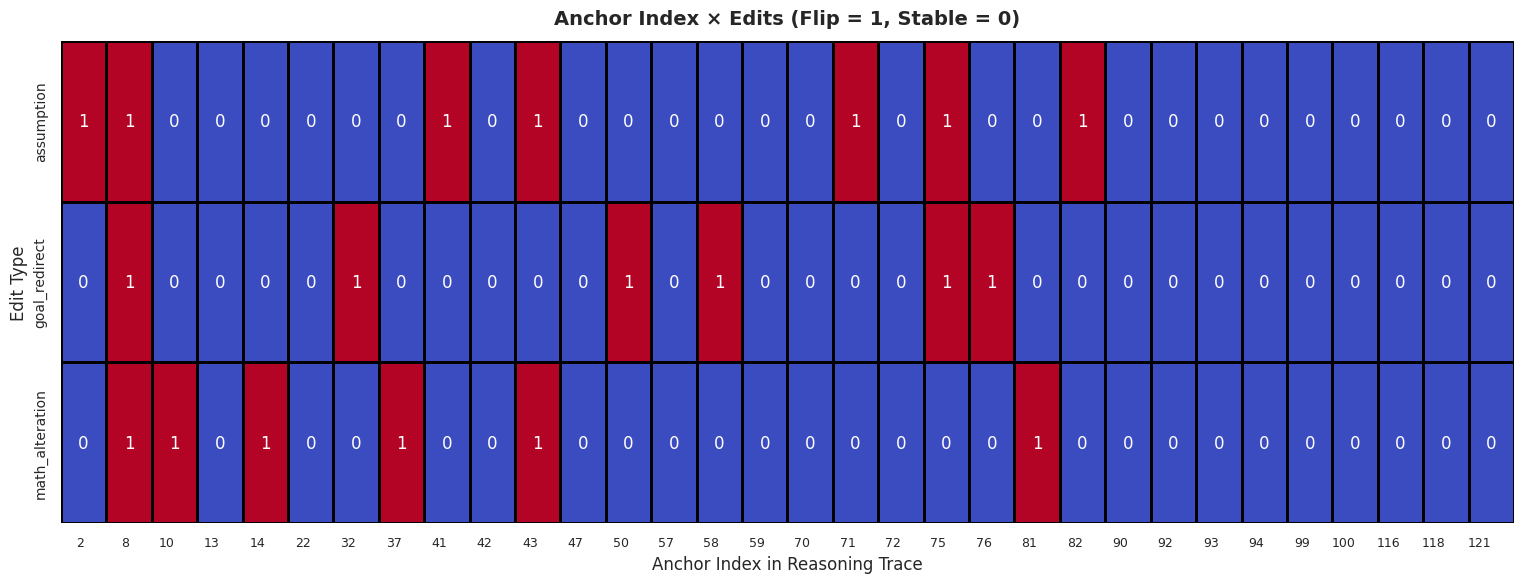

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1) Load results
# -----------------------------
try:
    df = df_res.copy()  # if you already have df_res in memory
except NameError:
    df = pd.read_csv("results.csv")  # fallback to CSV

# Ensure required columns exist
required = {"anchor_chunk_idx", "edit_type", "answer_changed"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in dataframe: {missing}")

# -----------------------------
# 2) Aggregate → binary (0/1)
#    If multiple trials per (anchor, edit_type),
#    take the mean then threshold at 0.5 → {0,1}
# -----------------------------
agg = (
    df.groupby(["edit_type", "anchor_chunk_idx"])["answer_changed"]
      .mean()
      .reset_index()
)

# Cast anchor index numeric & sort horizontally
agg["anchor_chunk_idx"] = pd.to_numeric(agg["anchor_chunk_idx"], errors="coerce")
agg = agg.dropna(subset=["anchor_chunk_idx"]).sort_values("anchor_chunk_idx")

# Pivot to rows=edit_type, cols=anchor, values=mean change
pivot = agg.pivot(index="edit_type", columns="anchor_chunk_idx", values="answer_changed")

# Threshold to binary 0/1 for display (since we only care flip/no-flip)
pivot_bin = (pivot >= 0.5).astype(int)

# -----------------------------
# 3) Plot styling
# -----------------------------
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titleweight": "bold",
    "axes.labelweight": "regular",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 9,
    "ytick.labelsize": 10,
})

# Wide figure: anchors laid out horizontally
fig, ax = plt.subplots(figsize=(min(24, 1 + 0.45 * pivot_bin.shape[1]), 6))

hm = sns.heatmap(
    pivot_bin,
    ax=ax,
    cmap="coolwarm",
    vmin=0, vmax=1,
    cbar=False,
    annot=True, fmt=".0f",
    linewidths=0.75, linecolor="black"
)

ax.set_title("Anchor Index × Edits (Flip = 1, Stable = 0)", pad=12)
ax.set_xlabel("Anchor Index in Reasoning Trace")
ax.set_ylabel("Edit Type")

# 🔑 Make anchor indices appear vertically
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()


In [ ]:
# Basic sanity (already in your code)
print("n trials:", len(df_res))
print("change rate:", df_res["answer_changed"].mean() if len(df_res) else 0.0)
print("post-edit accuracy:", df_res["final_correct"].mean() if len(df_res) else 0.0)

# Figures (saved as vector PDF)
fig_overall_metrics(df_res, path_pdf="fig_overall_metrics.pdf")
fig_change_by_edit(df_res, path_pdf="fig_change_by_edit.pdf")
fig_acc_delta_by_edit(df_res, path_pdf="fig_acc_delta_by_edit.pdf")

# Optional: per-anchor-role breakouts (requires anchor_tags)
fig_change_by_role_edit(df_res, path_pdf="fig_change_by_role_edit.pdf")
